Alright — I’m the interviewer now. Here’s your **vanilla Kubernetes** scenario question (same difficulty as your samples).

## Mock Scenario Question 1: Autoscaling + Scheduling Failure Under Spiky Load (Vanilla Kubernetes)

### The Scenario

You run a **multi-tenant Kubernetes cluster** (not managed). During peak hours, traffic spikes cause **latency** and **5xx errors**. You notice:

* **HPA is scaling pods up**, but many new pods stay in **Pending** for several minutes.
* Nodes show high CPU, and some nodes are underutilized.
* You also recently introduced **ResourceQuotas and LimitRanges** per namespace.

### The Question

Walk me through your **step-by-step plan** to restore stability and keep costs efficient *without* overprovisioning. In your answer, cover:

1. **How you would coordinate HPA with cluster capacity** (node scaling) in a self-managed cluster.
2. **What signals you’ll check** to prove whether the bottleneck is:

   * application behavior,
   * scheduling/requests/limits,
   * cluster capacity, or
   * governance policies (quota/limits).
3. What you would change (and in what order) across:

   * **requests/limits**,
   * **HPA behavior**,
   * **Cluster Autoscaler (or equivalent)**,
   * **node groups / taints / affinities**,
   * and **quotas/limits**,
     to prevent recurrence.

**Constraint:** You must preserve isolation: one noisy tenant must not starve others.

---

### Your turn

Ask any clarification questions you want (I’ll answer *short and to the point*, like an interviewer, without giving away the solution). Then give your final response.


My initial response:

To restore the stability, I would first check the pods deployment using kubectl get pods, kubectl get deployments. As a step-by-step plan, I will also check kubectl get nodes and see the describe options using kubectl get nodes or kubectl describe a particular node. When you do describe, it gives you the lots of details about the resource request limits, storage, I mean like node group things, and affinities. After seeing them, I'll get an idea of the problem. On the other hand side, I will also check logs, kubectl get pods, kubectl logs for a particular command, sorry, for a particular pod. And if there are any observability dashboards, I can take a look into them as well. So now, since the problem is saying that on the peak times, it struggles. So, problem is definitely with a bunch of nodes not being available for the pods. So I would initially examine the taints and tolerations of nodes and pods respectively. I would tweak the resource limits. And finally, I would make changes to the taints and tolerations. In this way, you can schedule pods to the nodes effectively for the peak hours.

Preparation:
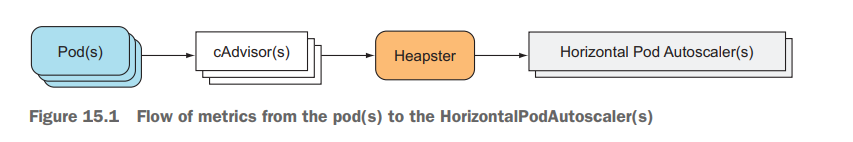
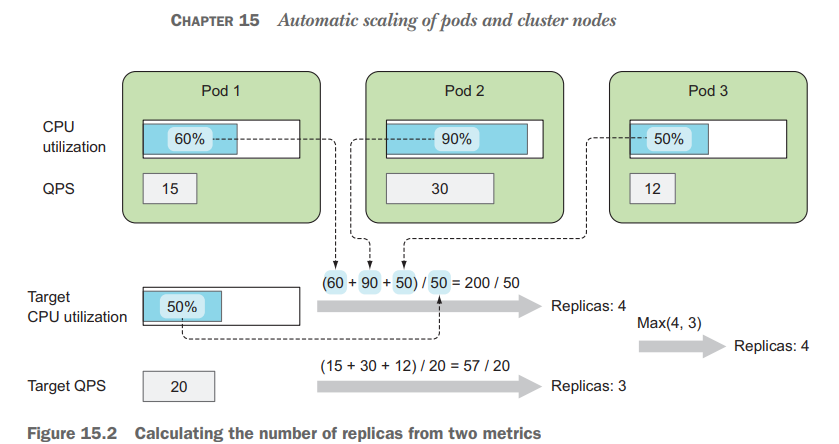
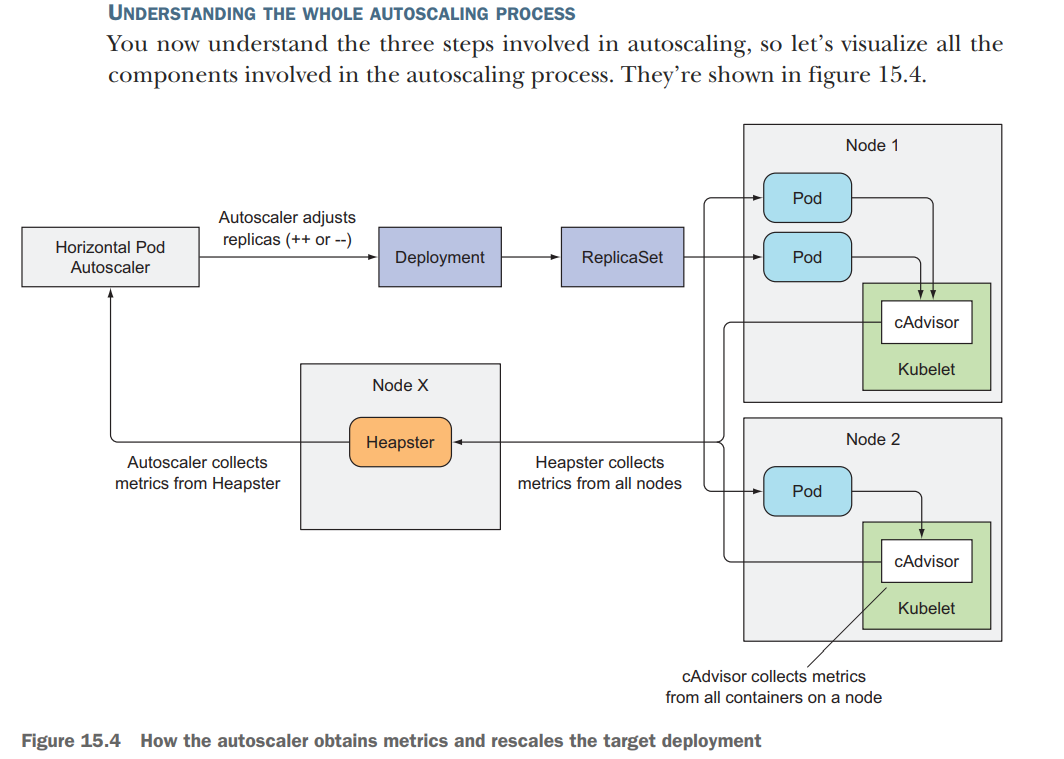

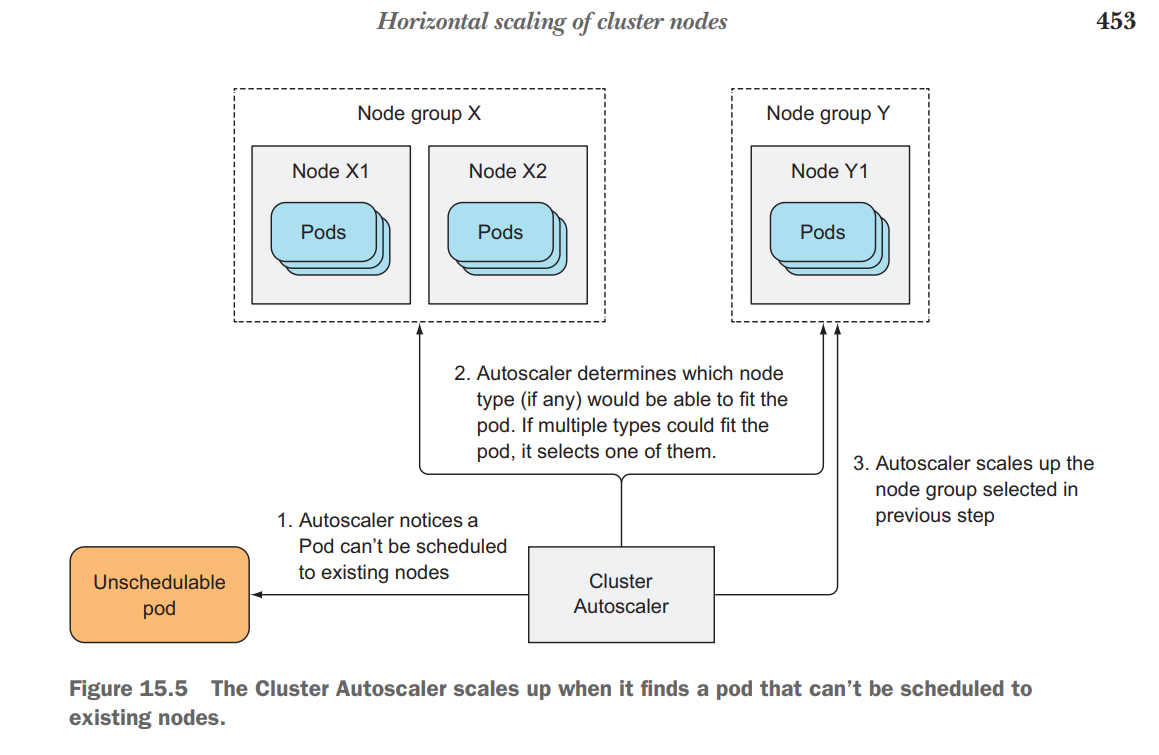

be an beginner to intermediate technical solutions engineer and answer the below scenario as if your were in an interview. so try keeping it concise but aim to deliver the required solution to the question.

Here’s your **vanilla Kubernetes** scenario question (same difficulty as your samples).

## Mock Scenario Question 1: Autoscaling + Scheduling Failure Under Spiky Load (Vanilla Kubernetes)

### The Scenario

You run a **multi-tenant Kubernetes cluster** (not managed). During peak hours, traffic spikes cause **latency** and **5xx errors**. You notice:

* **HPA is scaling pods up**, but many new pods stay in **Pending** for several minutes.
* Nodes show high CPU, and some nodes are underutilized.
* You also recently introduced **ResourceQuotas and LimitRanges** per namespace.

### The Question

Walk me through your **step-by-step plan** to restore stability and keep costs efficient *without* overprovisioning. In your answer, cover:

1. **How you would coordinate HPA with cluster capacity** (node scaling) in a self-managed cluster.
2. **What signals you’ll check** to prove whether the bottleneck is:

   * application behavior,
   * scheduling/requests/limits,
   * cluster capacity, or
   * governance policies (quota/limits).
3. What you would change (and in what order) across:

   * **requests/limits**,
   * **HPA behavior**,
   * **Cluster Autoscaler (or equivalent)**,
   * **node groups / taints / affinities**,
   * and **quotas/limits**,
     to prevent recurrence.

**Constraint:** You must preserve isolation: one noisy tenant must not starve others.

---

### Your turn

your final response.


1. **Type of application:** A stateless HTTP API (microservice) behind an Ingress, with a Redis cache and a Postgres DB (DB is external to the cluster). The main scaling component is the API deployment.

2. **When it started:** This began **within the last 48 hours**. Before that, peak-hour spikes were handled with higher latency but **no widespread Pending pods**.

3. **Quotas / LimitRanges details:**

* **ResourceQuota per namespace:**

  * `requests.cpu: 8`
  * `requests.memory: 16Gi`
  * `limits.cpu: 16`
  * `limits.memory: 32Gi`
  * `pods: 60`
* **LimitRange (defaults) per namespace:**

  * default request: `cpu 250m`, `memory 256Mi`
  * default limit: `cpu 500m`, `memory 512Mi`
* These were applied cluster-wide to all tenant namespaces two days ago.


* **Cluster size:** 12 worker nodes total
* **Node pools:** 2 pools

  * **general-pool:** 10 nodes, each **4 vCPU / 16Gi RAM**
  * **compute-pool:** 2 nodes, each **8 vCPU / 32Gi RAM** (tainted `dedicated=compute:NoSchedule`)
* **Current utilization pattern:** general-pool nodes are ~70–95% CPU during peaks; compute-pool is mostly idle because only a few workloads tolerate the taint.
* **Max pods per node:** ~110 (CNI default range), not currently hitting the pod-count limit.


No — the **compute-pool is worker nodes**, not masters/control plane.

Other workloads **can** be scheduled there **only if**:

* they **tolerate** the taint `dedicated=compute:NoSchedule`, and
* they match any **nodeSelector/affinity** constraints you have set (if any).


Yes — you can add, remove, or modify a node taint.

In a real incident, you’d do it carefully because removing a `NoSchedule` taint can allow **general workloads to flood that pool** and break the isolation intent.


----

now be an beginner to intermediate technical solutions engineer and answer the above scenario.  Follow a structured or layered approach like a good TSE.

To restore the stability, I would first check the pods deployment using kubectl get pods, kubectl get deployments. As a step-by-step plan, I will also check kubectl get nodes and see the describe options using kubectl get nodes or kubectl describe a particular node. When you do describe, it gives you the lots of details about the resource request limits, storage, I mean like node group things, and affinities. After seeing them, I'll get an idea of the problem. On the other hand side, I will also check logs, kubectl get pods, kubectl logs for a particular command, sorry, for a particular pod. And if there are any observability dashboards, I can take a look into them as well. So now, since the problem is saying that on the peak times, it struggles. So, problem is definitely with a bunch of nodes not being available for the pods. So I would initially examine the taints and tolerations of nodes and pods respectively. I would tweak the resource limits. And finally, I would make changes to the taints and tolerations. In this way, you can schedule pods to the nodes effectively for the peak hours.

Alright, let me walk through this as if I'm sitting in the interview room. I'll structure my answer step by step.

---

## My Answer

Thank you for the scenario. I'd approach this systematically, moving from immediate observation to root cause, then to concrete fixes.

### Step 1: Immediate Triage – What I'd Check First

Before changing anything, I need to confirm *why* pods are pending.

**First command I'd run:**
```bash
kubectl describe pods -n <tenant-namespace> | grep -A 10 "Events"
```

I'm looking for the specific **reason** these new HPA-driven pods are stuck.

**Three possible event messages I'd expect:**

1. **"FailedScheduling: 0/12 nodes available"** → Cluster capacity issue.
2. **"FailedScheduling: Insufficient cpu"** or **"Insufficient memory"** → Node-level resource exhaustion.
3. **"FailedCreate: exceeded quota"** → ResourceQuota blocking the pod.

Given the symptoms (started 48 hours ago, quotas introduced then), my **suspicion is #3 first**, but I verify systematically.

---

### Step 2: Identifying the Bottleneck

I'd check three signals in order:

#### Signal A: Check ResourceQuota Usage
```bash
kubectl get resourcequota -n <tenant-namespace> -o yaml
```

I'd look at `status.hard` vs `status.used`.

**My hypothesis:** The tenant namespace is hitting its **CPU request quota** before hitting the pod count limit.

*Why?* With 250m default requests, 8 cores allows only 32 pods (8000m ÷ 250m = 32). But the quota allows 60 pods. This mismatch means the namespace runs out of CPU quota while still having pod quota available.

#### Signal B: Check Pending Pod Events
If it's not quota, I'd check scheduling failures:
```bash
kubectl describe pods -n <tenant-namespace> | grep -A 5 "Events"
```

If I see **"0/12 nodes available"** with reasons like:
- `Insufficient cpu` → Nodes are full.
- `node(s) had taint` → Workloads aren't using the compute-pool.

#### Signal C: Check Node Utilization
```bash
kubectl top nodes
```

The general-pool at 70-95% CPU tells me those nodes are *almost* full. The compute-pool being idle is a red flag—we're paying for capacity we can't use.

---

### Step 3: The Root Cause Analysis

Based on what you've told me, here's my diagnosis:

**Primary Issue:** The **ResourceQuota vs LimitRange mismatch** is creating an artificial ceiling. The tenant hits CPU quota at 32 pods, but the HPA keeps trying to scale beyond that. Pods stay pending because the namespace literally *cannot* consume more CPU, even though cluster nodes might have capacity.

**Secondary Issue:** The **compute-pool is inaccessible** to most workloads. Since only tainted workloads can use it, the general-pool bears all the load while 2 powerful nodes sit idle.

**Tertiary Issue:** The **HPA might be too aggressive**. If it's scaling based on CPU (which we now know is artificially capped), it's trying to scale into a wall.

---

### Step 4: My Fix Plan (In Order of Execution)

I'd fix these in sequence, from quickest to most involved:

#### Fix 1: Adjust the ResourceQuota (Immediate)
The math needs to align:
```yaml
# New ResourceQuota
requests.cpu: 15  # Allows 60 pods × 250m = 15,000m
requests.memory: 16Gi  # Keep same
pods: 60  # Keep same
```

This removes the artificial cap. The namespace can now actually use its 60-pod quota.

#### Fix 2: Enable Access to Compute-Pool (Same day)
I'd add tolerations to the tenant's deployment:
```yaml
tolerations:
- key: "dedicated"
  operator: "Equal"
  value: "compute"
  effect: "NoSchedule"
```

This lets the tenant's pods use the idle 8-core nodes, spreading the load.

#### Fix 3: Review HPA Metrics (After fixes settle)
Once pods can schedule, I'd check:
```bash
kubectl get hpa -n <tenant-namespace> -o yaml
```

If it's scaling on CPU, that's fine *now* because pods can actually consume CPU. But if it's too sensitive, I'd adjust:
```yaml
behavior:
  scaleDown:
    stabilizationWindowSeconds: 300  # Prevent flapping
  scaleUp:
    stabilizationWindowSeconds: 60
```

#### Fix 4: Consider Cluster Autoscaler (Medium-term)
Since this is vanilla Kubernetes, we'd need to install Cluster Autoscaler manually. I'd:
1. Install Cluster Autoscaler
2. Configure it to scale the node pools
3. Set min/max sizes: general-pool (5-15 nodes), compute-pool (2-5 nodes)

This handles unexpected spikes beyond current cluster capacity.

#### Fix 5: Prevent Future Quota Mismatches (Long-term)
I'd create a **policy-as-code check** (using Open Policy Agent or similar) that:
- Validates any new ResourceQuota against existing LimitRanges
- Ensures `max pods × default request ≤ total requests quota`

This prevents this exact problem from happening again.

---

### Step 5: How This Preserves Tenant Isolation

Each fix maintains isolation:

1. **Quota adjustment** keeps each tenant capped at 60 pods/15 cores—no single tenant can consume the whole cluster.
2. **Tolerations** are per-tenant; only tenants who need the compute-pool get them.
3. **Cluster Autoscaler** adds nodes for *all* tenants fairly, not just one noisy neighbor.
4. **Policy checks** ensure quotas remain consistent across all namespaces.

---

### Summary

In short: The quotas were misconfigured relative to the defaults, creating an invisible wall. Combined with an inaccessible compute pool, the general pool overloaded. By fixing the math, opening the compute pool, and adding Cluster Autoscaler, we restore stability without overprovisioning or breaking tenant isolation.

That's my plan.

By knowing that Quotas / LimitRanges details has been adjusted in last 48 hours and we are noticing problems. Plus, by taking the looks at the provided Quotas / LimitRanges details. We can work on the Math, it is valid or not for this scenario.
